In [8]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import pandas as pd
import mdtraj as md
import scipy.stats as st
import nglview as nv
import MDAnalysis as mda
from nglview.datafiles import PDB,XTC
from scipy.spatial.distance import cdist
%matplotlib inline

In [9]:


class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

In [2]:
mm = md.load('/home/btopal/pQ_sims/KKPGASL4Q16KK/charmm/200ns/3/5ms_nowater_16q.xtc', 
             top='/home/btopal/pQ_sims/KKPGASL4Q16KK/charmm/200ns/3/2ms_nowater_16q.pdb')
# mm = md.load('/home/btopal/cs_analysis/charmm/16q/combined.xtc', 
#              top='/home/btopal/cs_analysis/charmm/16q/cs_pro_0.pdb')
# mm.time = np.linspace(0,5000,mm.n_frames)
# mm = mm[::5]
topmm = mm.top

In [3]:
LO, LH, QO, QH, QHE22, QHE21 = ([] for i in range(6)) 
# LO, LH, QO, QH, QHE22, QHE21 = ({} for i in range(6)) 

for i in range(6,10):
    LO.append(topmm.select('resid {} and name O'.format(i))[0])
    LH.append(topmm.select('resid {} and name H'.format(i))[0])

for i in range(10,26):
    QO.append(topmm.select('resid {} and name O'.format(i))[0])
    QH.append(topmm.select('resid {} and name H'.format(i))[0])
    QHE21.append(topmm.select('resid {} and name HE21'.format(i))[0]) 
    QHE22.append(topmm.select('resid {} and name HE22'.format(i))[0]) 



In [225]:
new_weights = '/home/btopal/fishing/16q/cs_0002.weights.dat' 
pdb_weight = {}
index = 0  
with open(new_weights, 'r') as inp:
    for line in inp.readlines():
        if line.startswith('#'):
            continue
        else:
            split = line.split()
            weight = split[1]
            pdb_weight[str(index)] = float(weight)
            index = index + 1
            


pdb_list = '/home/btopal/fishing/16q/ens_file.tab'
pdb_data = {}
with open(pdb_list, 'r') as inp:
    for line in inp.readlines():
        if line.startswith('#'):
            continue
        else:
            split = line.split()
            pdbnum = int(split[0])
            pdbname = int(split[1][4:-4])
            pdb_data[pdbname] = pdbnum

In [226]:
w_list = []
for i in range(len(pdb_weight)):
    w_list.append(pdb_weight[str(pdb_data[i])])
    

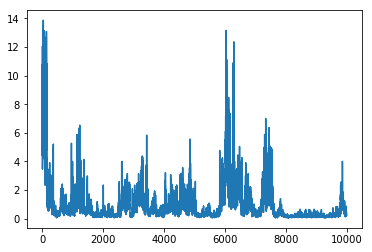

In [28]:
# w_list[999]
plt.plot(np.asarray(w_list)*10000)


In [227]:
####HELICITY
ssl = md.compute_dssp(mm,simplified=True)
sslh = (ssl=='H').astype(np.float)
sslh

array([[0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
pairs = np.array(((LO[0], QH[0]),
    (LO[0], QHE21[0]),
    (LO[0], QHE22[0]),
    (LO[0], LH[3]),
    (QO[11], QHE21[15]),
    (QO[11], QHE22[15]),))
dists = md.compute_distances(mm, pairs)*10

In [16]:
###L1-Q1
hbonded_bb = dists[:,0]<2.4
np.where(hbonded_bb)[0].shape

(14660,)

In [11]:
# hbonded_1 = dists[:,1:3].min(1)<2.4
hbonded_1 = dists[:,2]<2.4
np.where(hbonded_1)[0]

array([   26,    49,    51, ..., 49650, 49692, 49700])

In [20]:
np.mean(dists[:,2][hbonded_1])

2.0981972

In [21]:
np.mean(dists[:,0][hbonded_1])

2.5873961

In [18]:

hh = np.logical_and(hbonded_bb, hbonded_1)
hh.sum()

1046

In [35]:
helical = np.all(sslh[:,4:13]>0,1)
h_b = np.logical_and(helical, hh)
helical.sum()

823

In [20]:
sc_b = np.logical_and(helical, hbonded_1)
sc_b.sum()

374

In [71]:
np.array(w_list)[hh].sum()

0.039032119

In [73]:
np.array(w_list)[hbonded_1].sum()

0.07377229399999999

In [74]:
np.array(w_list)[hbonded_bb].sum()

0.516269082

In [210]:
np.arange(0,50000)[helical][3027]

36132

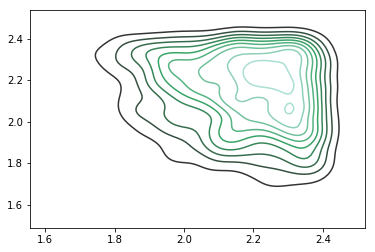

In [223]:
sns.kdeplot(np.array(dists[:,0])[hh],np.array(dists[:,2])[hh])
# plt.scatter(np.array(dists[:,0]),np.array(dists[:,2]))
# plt.ylim([1.5,5])
# plt.xlim([1.5,5])

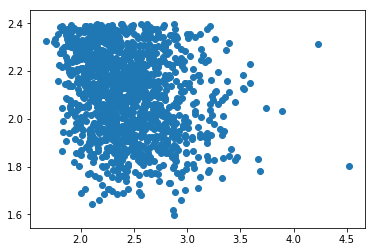

In [171]:
plt.scatter(np.array(dists[:,0])[sc_b],np.array(dists[:,2])[sc_b])

In [218]:
deneme = md.load('calc_hel.pdb', top='calc_hel.pdb')
hel_deneme = md.compute_dssp(deneme,simplified=True)
hel_deneme

/home/btopal/.local/lib/python2.7/site-packages/mdtraj/core/trajectory.py:419: UserWarning: top= kwarg ignored since file contains topology information
  warnings.warn('top= kwarg ignored since file contains topology information')


array([['C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
        'C', 'C']], dtype='|S2')

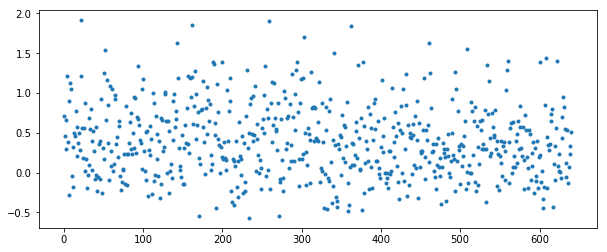

In [164]:
plt.figure(figsize=(10,4))
plt.plot(np.array(dists[:,0])[sc_b]-np.array(dists[:,2])[sc_b],'.')
# plt.xlim([0,200])

In [36]:
###Q12-Q16
hbonded_16 = dists[:,4:5].min(1)<2.4
np.where(hbonded_16)[0].shape


(42,)

In [37]:
###helical res 6:11 (L1-Q1)

helical = np.all(sslh[:,6:11]>0,1)
helical

helical_16 = np.all(sslh[:,22:26]>0,1)
helical_16

array([ True, False,  True, ..., False, False, False])

In [38]:
####helical and hbonded

hh = np.logical_and(helical, hbonded_1)
hh.sum()

hh_16 = np.logical_and(helical_16, hbonded_16)
hh_16.sum()

6

# Side-Chain Clustering

(10000, 26)

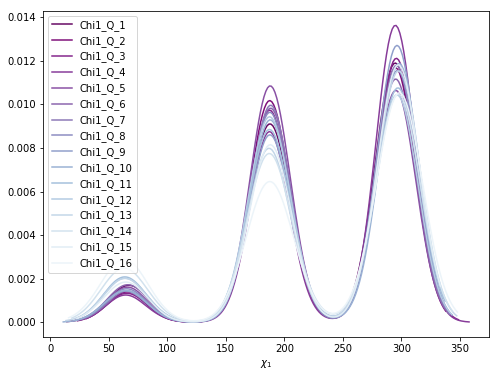

In [205]:
plt.figure(figsize=(8,6))
mycolors = sns.color_palette('BuPu_r',n_colors=16)
chis1 = md.compute_chi1(mm)[1]
chi1_1 = np.rad2deg(np.where(chis1[:,8]<0,chis1[:,8]+2*np.pi,chis1[:,8] ))
chi1_16 = np.rad2deg(np.where(chis1[:,23]<0,chis1[:,23]+2*np.pi,chis1[:,23] ))

# chi1_1 = np.rad2deg(chis1[:,8] )
# chi1_16 = np.rad2deg(chis1[:,23])

# chi1_1 = np.rad2deg(chis1[:,8] )

# sns.kdeplot(chi1_1,shade=True, label="Q1_all") 
# sns.kdeplot(chi1_1[hbonded_1],shade=True, label="Q1-sc-scbonded", c='#990000') 
# sns.kdeplot(chi1_16, label="Q16_all") 
# sns.kdeplot(chi1_16[hbonded_16], label="Q16-sc-scbonded") 

for i in range(16):
    chi1 = np.rad2deg(np.where(chis1[:,i+8]<0,chis1[:,i+8]+2*np.pi,chis1[:,i+8] ))
    pdf_c1 = gaussian_kde(chi1, weights=w_list)
    x_c1 = np.linspace(min(chi1), max(chi1), 200)
    y_c1 = pdf_c1(x_c1)
    plt.plot(x_c1, y_c1, label="Chi1_Q_%s"%str(i+1),color=mycolors[i])



#sns.kdeplot(np.rad2deg(chis[:,9:12].mean(0)), shade=True, label="Gln12-14") 
#sns.kdeplot(np.rad2deg(chis[:,12:16].mean(1)), shade=True, label="Gln15-18")
plt.legend(loc='best')
plt.xlabel(r'$\chi_1$');
#plt.xlim(-180,180)
chis1.shape

(10000, 25)

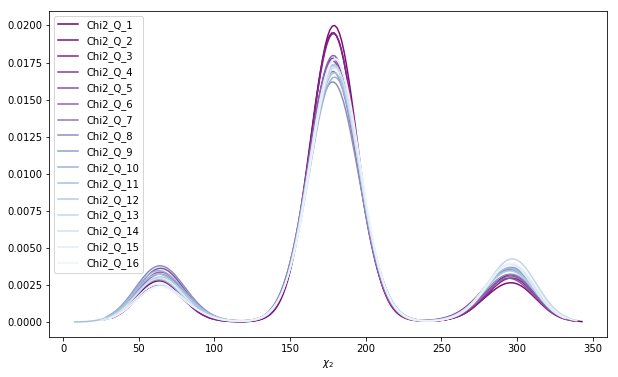

In [202]:
plt.figure(figsize=(10,6))
# chis2 = md.compute_chi2(mm)[1]
chi2_1 = np.rad2deg(np.where(chis2[:,7]<0,chis2[:,7]+2*np.pi,chis2[:,7] ))
# chi2_1 = np.rad2deg(chis2[:,7])

chi2_16 = np.rad2deg(np.where(chis2[:,22]<0,chis2[:,22]+2*np.pi,chis2[:,22] ))
# chi2_16 = np.rad2deg(chis2[:,22])
# chi2_1 = np.rad2deg(chis2[:,7])#990000
# sns.kdeplot(chi2_1,shade=True, label="Q1-all") 
# sns.kdeplot(chi2_1[hbonded_1],shade=True, label="Q1-sc-scbonded", c='#990000') 
# sns.kdeplot(chi2_16, label="Q16-all") #990000
# sns.kdeplot(chi2_16[hh_16], label="Q16-sc-scbonded") 
#sns.distplot(np.rad2deg(chis[:,8]), label="Gln12") 
#sns.kdeplot(np.rad2deg(chis[:,9]), shade=True, label="Gln13")

for i in range(16):
    chi2 = np.rad2deg(np.where(chis2[:,i+7]<0,chis2[:,i+7]+2*np.pi,chis2[:,i+7] ))
    pdf_c2 = gaussian_kde(chi2, weights=w_list)
    x_c2 = np.linspace(min(chi2), max(chi2), 200)
    y_c2 = pdf_c2(x_c2)
    plt.plot(x_c2, y_c2, label="Chi2_Q_%s"%str(i+1),color=mycolors[i])

plt.legend(loc='best')
plt.xlabel(r'$\chi_2$');
chis2.shape

(10000, 20)

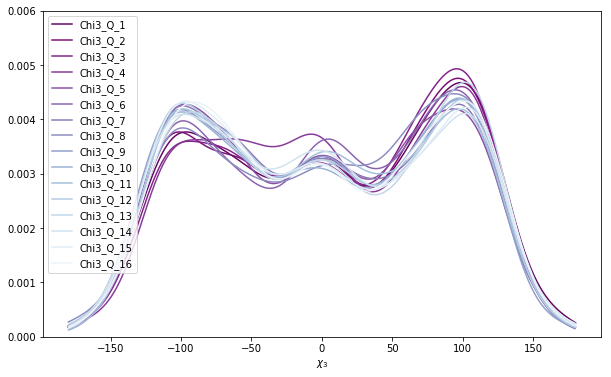

In [51]:
plt.figure(figsize=(10,6))
chis3 = md.compute_chi3(mm)[1]
chi3_1 = np.rad2deg(chis3[:,2])
chi3_16 = np.rad2deg(chis3[:,17])
# sns.kdeplot(chi3_1, shade=True, label="Q1-all") 
# sns.kdeplot(chi3_1[hbonded_1], shade=True, label="Q1-sc-scbonded", c='#990000') 
# sns.kdeplot(chi3_16, shade=True, label="Q16-all") 
# sns.kdeplot(chi3_16[hh_16], shade=True, label="Q16-sc-scbonded") 
# sns.kdeplot(np.rad2deg(chis[:,3]), shade=True, label="Gln12") 
# sns.kdeplot(np.rad2deg(chis[:,4]), shade=True, label="Gln13")

for i in range(16):
    chi3 = np.rad2deg(chis3[:,i+2])
    pdf_c3 = gaussian_kde(chi3, weights=w_list)
    x_c3 = np.linspace(min(chi3), max(chi3), 200)
    y_c3 = pdf_c3(x_c3)
    plt.plot(x_c3, y_c3, label="Chi3_Q_%s"%str(i+1),color=mycolors[i])

plt.legend(loc='best')
plt.ylim(0,0.006)
plt.xlabel(r'$\chi_3$');
chis3.shape

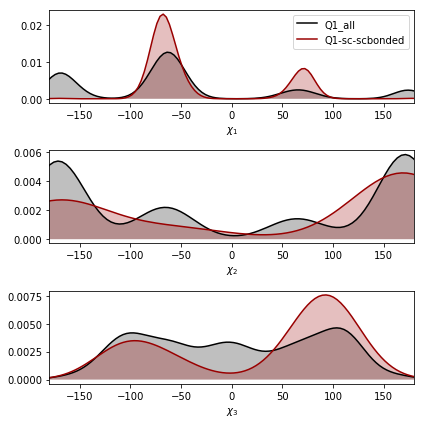

In [148]:
plt.figure(figsize=(6,6))
plt.subplot(311)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        v
sns.kdeplot(chi1_1[hbonded_1],shade=True, label="Q1-sc-scbonded", c='#990000') 
plt.xlabel(r'$\chi_1$');
plt.xlim(-180,180)

plt.subplot(312)
sns.kdeplot(chi2_1,shade=True,c='k') 
sns.kdeplot(chi2_1[hbonded_1],shade=True,c='#990000') 
plt.xlabel(r'$\chi_2$');
plt.xlim(-180,180)

plt.subplot(313)
sns.kdeplot(chi3_1,shade=True,c='k') 
sns.kdeplot(chi3_1[hbonded_1],shade=True, c='#990000') 
plt.xlabel(r'$\chi_3$');
plt.xlim(-180,180)

plt.tight_layout()
# plt.savefig('chis.png', dpi=200)


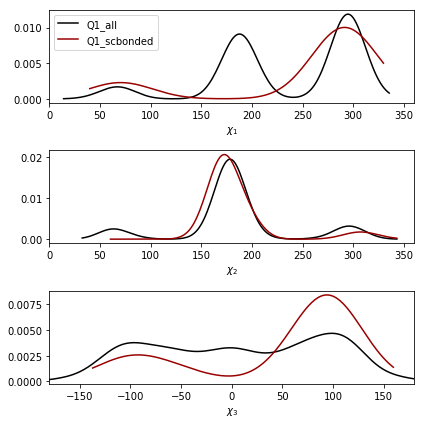

In [113]:
# pdf_c2 = gaussian_kde(chi2, weights=w_list)
# x_c2 = np.linspace(min(chi2), max(chi2), 200)
# y_c2 = pdf_c2(x_c2)
# plt.plot(x_c3, y_c3, label="Chi3_Q_%s"%str(i+1),color=mycolors[i])


plt.figure(figsize=(6,6))
plt.subplot(311)

pdf_c1 = gaussian_kde(chi1_1, weights=w_list)
x_c1 = np.linspace(min(chi1_1), max(chi1_1), 200)
y_c1 = pdf_c1(x_c1)
plt.plot(x_c1, y_c1, label="Q1_all", color='k')

pdf_c1b = gaussian_kde(chi1_1[hbonded_1], weights=np.array(w_list)[hbonded_1])
x_c1b = np.linspace(min(chi1_1[hbonded_1]), max(chi1_1[hbonded_1]), 200)
y_c1b = pdf_c1b(x_c1b)
plt.plot(x_c1b, y_c1b,label="Q1_scbonded", color='#990000')
plt.legend()

plt.xlabel(r'$\chi_1$');
plt.xlim(0,360)

plt.subplot(312)
pdf_c2 = gaussian_kde(chi2_1, weights=w_list)
x_c2 = np.linspace(min(chi2_1), max(chi2_1), 200)
y_c2 = pdf_c2(x_c2)
plt.plot(x_c2, y_c2, color='k')

pdf_c2b = gaussian_kde(chi2_1[hbonded_1], weights=np.array(w_list)[hbonded_1])
x_c2b = np.linspace(min(chi2_1[hbonded_1]), max(chi2_1[hbonded_1]), 200)
y_c2b = pdf_c2b(x_c2b)
plt.plot(x_c2b, y_c2b, color='#990000')


# sns.kdeplot(chi2_1,shade=True,c='k') 
# sns.kdeplot(chi2_1[hbonded_1],shade=True,c='#990000') 
plt.xlabel(r'$\chi_2$');
plt.xlim(0,360)

plt.subplot(313)
pdf_c3 = gaussian_kde(chi3_1, weights=w_list)
x_c3 = np.linspace(min(chi3_1), max(chi3_1), 200)
y_c3 = pdf_c3(x_c3)
plt.plot(x_c3, y_c3, color='k')

pdf_c3b = gaussian_kde(chi3_1[hbonded_1], weights=np.array(w_list)[hbonded_1])
x_c3b = np.linspace(min(chi3_1[hbonded_1]), max(chi3_1[hbonded_1]), 200)
y_c3b = pdf_c3b(x_c3b)
plt.plot(x_c3b, y_c3b, color='#990000')

plt.xlabel(r'$\chi_3$');
plt.xlim(-180,180)

plt.tight_layout()
# plt.savefig('chis.png', dpi=200)

In [171]:
p=[ 88., 124., 131., 126., 133., 147., 161., 114., 119., 121., 120.,
        118., 119., 117., 115.,  87.,  83.,  84.,  60.,  70.,  56.,  67.,
         61.,  48.,  38.,  31.,  35.,  15.,  22.,  23.,  27.,  14.,   9.,
          7.,   6.,   9.,  10.,   6.,   6.,   3.,   2.,   2.,   1.,   4.,
          1.,   3.,   0.,   0.,   2.,   2.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   1.,   1.,
          0.,   1.,   2.,   3.,   1.,   1.,   2.,   2.,   0.,   6.,   3.,
          4.,   8.,  15.,  13.,  14.,  13.,  19.,  27.,  20.,  41.,  40.,
         61.,  56.,  68.,  90.,  78., 108., 109., 106., 135., 133., 161.,
        163., 176., 176., 205., 222., 199., 207., 198., 207., 192., 184.,
        189., 169., 160., 166., 143., 137., 130., 125., 102.,  84.,  86.,
         69.,  43.,  58.,  46.,  22.,  23.,  27.,  23.,  12.,  13.,  12.,
          8.,   9.,   7.,   7.,   7.,   9.,   1.,   1.,   0.,   0.,   1.,
          2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   2.,   3.,   0.,   2.,   1.,   5.,   3.,
          3.,   1.,   7.,   4.,   7.,   7.,   5.,  13.,  15.,  22.,  19.,
         13.,  25.,  23.,  22.,  18.,  32.,  17.,  32.,  33.,  21.,  37.,
         47.,  39.,  25.,  37.,  32.,  34.,  41.,  37.,  48.,  33.,  30.,
         33.,  18.,  25.,  22.,  18.,  18.,  22.,  20.,  11.,  14.,   8.,
         10.,  11.,   4.,   3.,   4.,   6.,   2.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   1.,   0.,   2.,   3.,   2.,   4.,   1.,   5.,   4.,
          7.,   9.,  13.,   8.,  19.,  23.,  26.,  26.,  31.,  36.,  30.,
         46.,  56.,  65.,  69.,  75.,  80., 100.,  88.]

<IPython.core.display.Javascript object>


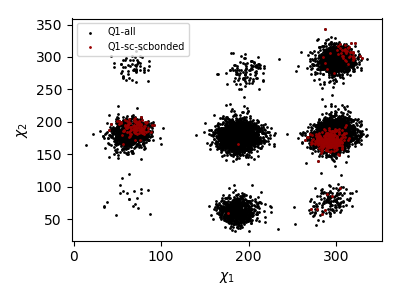

In [107]:
plt.figure(figsize=(4,3))
plt.scatter(chi1_1,chi2_1, s=1, c='k', label="Q1-all") 
plt.scatter(chi1_1[hbonded_1],chi2_1[hbonded_1],  c='#990000', s=1, label="Q1-sc-scbonded") 
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend(loc='best', fontsize='x-small')
plt.tight_layout()
plt.savefig('2dchis.png', dpi=200)

<IPython.core.display.Javascript object>


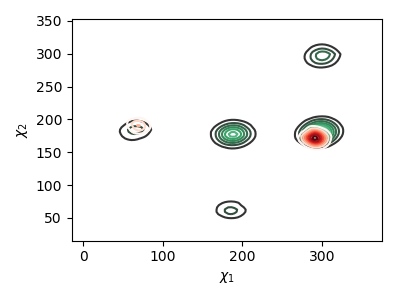

/home/btopal/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [58]:
plt.figure(figsize=(4,3))
sns.kdeplot(chi1_1, chi2_1, label="Q1-all")
sns.kdeplot(chi1_1[hbonded_1],chi2_1[hbonded_1], label="Q1-sc-scbonded", s=1, cmap="Reds") 
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend(loc='best', fontsize='x-small')
plt.tight_layout()
plt.savefig('2dchis_kde.png', dpi=200)

In [ ]:
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')

# # Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
# ax.plot3D(xline, yline, zline, 'gray')

ax = plt.axes(projection='3d')
# plt.plot(chi1,chi2, '.', color='r') 
ax.plot3D(chi1_1,chi2_1,chi3_1, '.') 
ax.plot3D(chi1_1[hbonded_1],chi2_1[hbonded_1],chi3_1[hbonded_1], '.') 
ax.plot3D(chi1_16[hbonded_16],chi2_16[hbonded_16],chi3_16[hbonded_16], '.') 

In [ ]:
X16 = np.array([chi1_16, chi2_16, chi3_16]).T
X16

In [ ]:
outfile = "chi_16"
np.save(outfile, X16)

<IPython.core.display.Javascript object>


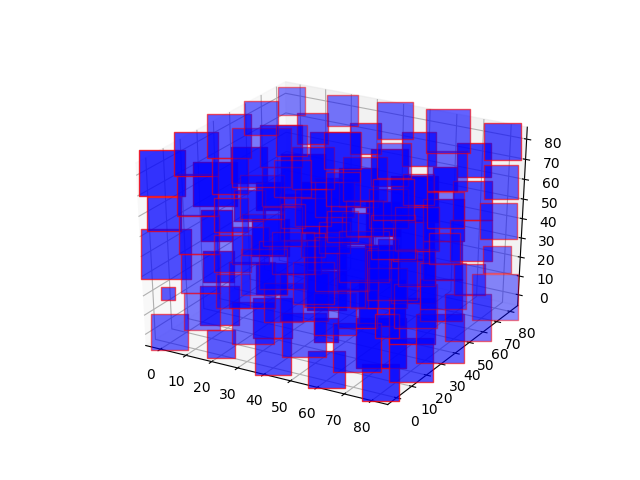

In [22]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Generating some random data.
data = np.random.randint(0, 100, (1000,3))
x, y, z = data[:, 0], data[:, 1], data[:, 2]

# Generating raw view
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, marker='+', s=25, c='r')
# plt.show()

# Generating some grid with origin, cell size, and number of cells 10 10 10
numx, numy, numz = 5, 5, 5
origx, origy, origz = 0, 0, 0
sizex, sizey, sizez = 20, 20, 20
grid = np.vstack(np.meshgrid(range(numx), range(numy), range(numz))).reshape(3, -1).T
gx, gy, gz = grid[:, 0]*sizex + origx, grid[:, 1]*sizey + origy, grid[:, 2]*sizez + origz

# Calculating the number of stars in each cell:
ix = ((x - origx)/sizex).astype(int)
iy = ((y - origy)/sizey).astype(int)
iz = ((z - origz)/sizez).astype(int)
s = np.zeros((numx, numy, numz))
for i in range(ix.shape[0]):
    s[ix[i], iy[i], iz[i]] = s[ix[i], iy[i], iz[i]]+1
s = s.flatten()
mask = s > 0

# Plotting the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gx[mask], gy[mask], gz[mask], marker='s', s=s[mask]*100, c='b', edgecolor ="r")
plt.show()

In [114]:
ix

array([2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

<IPython.core.display.Javascript object>


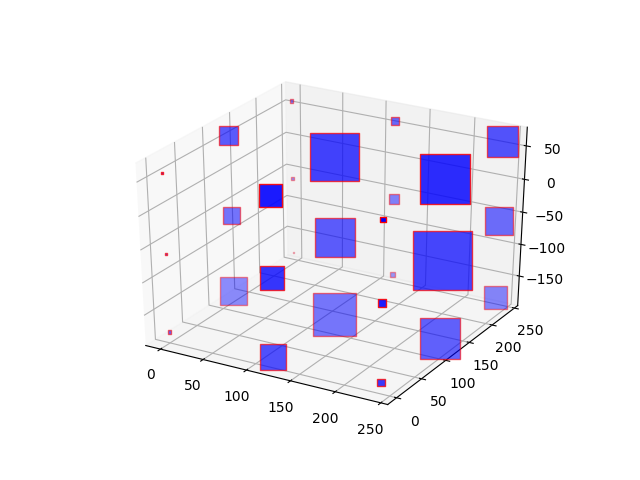

In [153]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Generating some random data.
data = np.random.randint(0, 100, (1000,3))
x, y, z = chi1_1, chi2_1, chi3_1

# Generating raw view
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, marker='+', s=25, c='r')
# plt.show()

# Generating some grid with origin, cell size, and number of cells 10 10 10
numx, numy, numz = 3, 3, 3
origx, origy, origz = 0, 0, -180
sizex, sizey, sizez = 120, 120, 120
grid = np.vstack(np.meshgrid(range(numx), range(numy), range(numz))).reshape(3, -1).T
gy, gx, gz = grid[:, 0]*sizex + origx, grid[:, 1]*sizey + origy, grid[:, 2]*sizez + origz

# Calculating the number of stars in each cell:
ix = ((x - origx)/sizex).astype(int)
iy = ((y - origy)/sizey).astype(int)
iz = ((z - origz)/sizez).astype(int)
s = np.zeros((numx, numy, numz))
for i in range(ix.shape[0]):
#     print s[ix[i], iy[i], iz[i]]
    s[ix[i], iy[i], iz[i]] = s[ix[i], iy[i], iz[i]] + (1 *w_list[i]*10000)
    
s = s.flatten()
mask = s > 0

# Plotting the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gx[mask], gy[mask], gz[mask], marker='s', s=s[mask], c='b', edgecolor ="r")

plt.show()

<IPython.core.display.Javascript object>


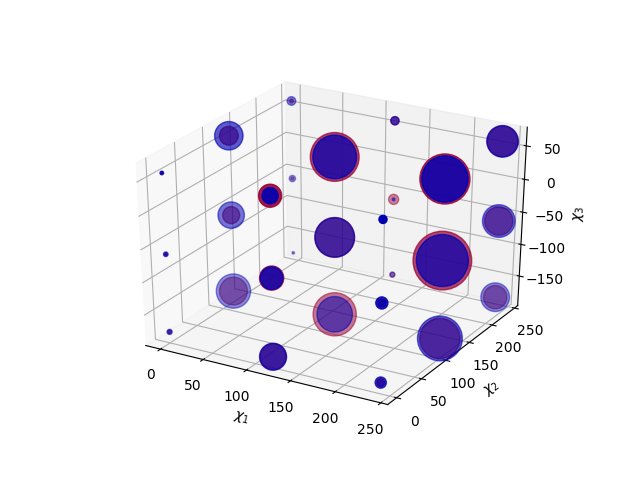

In [154]:
data = np.random.randint(0, 100, (1000,3))
x, y, z = chi1_16, chi2_16, chi3_16

# Generating raw view
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, marker='+', s=25, c='r')
# plt.show()

# Generating some grid with origin, cell size, and number of cells 10 10 10
numx, numy, numz = 3, 3, 3
origx, origy, origz = 0, 0, -180
sizex, sizey, sizez = 120, 120, 120
grid = np.vstack(np.meshgrid(range(numx), range(numy), range(numz))).reshape(3, -1).T
gy, gx, gz = grid[:, 0]*sizex + origx, grid[:, 1]*sizey + origy, grid[:, 2]*sizez + origz

# Calculating the number of stars in each cell:
ix = ((x - origx)/sizex).astype(int)
iy = ((y - origy)/sizey).astype(int)
iz = ((z - origz)/sizez).astype(int)
s16 = np.zeros((numx, numy, numz))
for i in range(ix.shape[0]):
#     print s[ix[i], iy[i], iz[i]]
    s16[ix[i], iy[i], iz[i]] = s16[ix[i], iy[i], iz[i]] + (1*w_list[i]*10000)
    
s16 = s16.flatten()
mask = s16 > 0

# Plotting the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gx[mask], gy[mask], gz[mask], marker='o', s=s[mask], c='#990033', edgecolor ="#990033", label='Q1')
ax.scatter(gx[mask], gy[mask], gz[mask], marker='o', s=s16[mask], c='#0000b3', edgecolor ="#0000b3" ,label='Q1')
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');

ax.set_zlabel(r'$\chi_3$')
# plt.zlabel(r'$\chi_3$');
plt.savefig('3d_part.png', dpi=200)
plt.show()

<IPython.core.display.Javascript object>


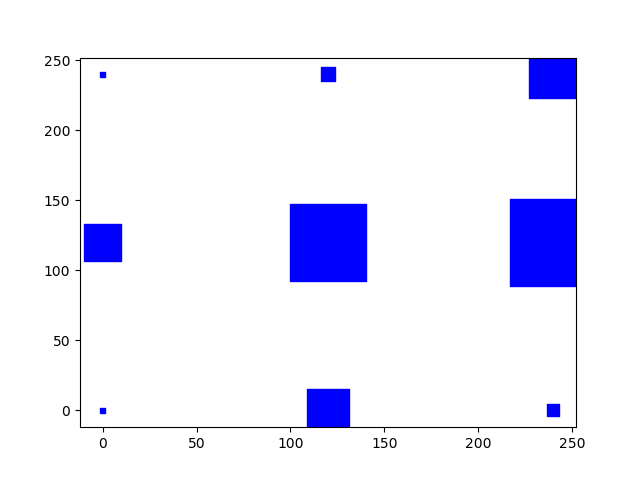

In [171]:
import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# Generating some random data.
# data = np.random.randint(0, 100, (1000,3))
x, y = chi1_1, chi2_1

# Generating raw view
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, marker='+', s=25, c='r')
# plt.show()

# Generating some grid with origin, cell size, and number of cells 10 10 10
numx, numy= 3, 3
origx, origy = 0, 0
sizex, sizey= 120, 120
grid = np.vstack(np.meshgrid(range(numx), range(numy))).reshape(2, -1).T
gy, gx = grid[:, 0]*sizex + origx, grid[:, 1]*sizey + origy

# Calculating the number of stars in each cell:
ix = ((x - origx)/sizex).astype(int)
iy = ((y - origy)/sizey).astype(int)
s_2d = np.zeros((numx, numy))
c3_q1 = {}
for i in range(ix.shape[0]):
#     print s[ix[i], iy[i], iz[i]]
    s_2d[ix[i], iy[i]]= s_2d[ix[i], iy[i]] + (1 *w_list[i]*10000)
    name = str(ix[i])+str(iy[i])
    set_key(c3_q1, name, i)
    
s_2d = s_2d.flatten()
mask = s_2d > 0

# Plotting the result
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
plt.scatter(gx[mask], gy[mask], marker='s', s=s_2d[mask], c='b', edgecolor ="b")

plt.show()

In [168]:
def set_key(dictionary, key, value):
    if key not in dictionary:
         dictionary[key] = value
    elif type(dictionary[key]) == list:
        dictionary[key].append(value)
    else:
        dictionary[key] = [dictionary[key], value]

<IPython.core.display.Javascript object>


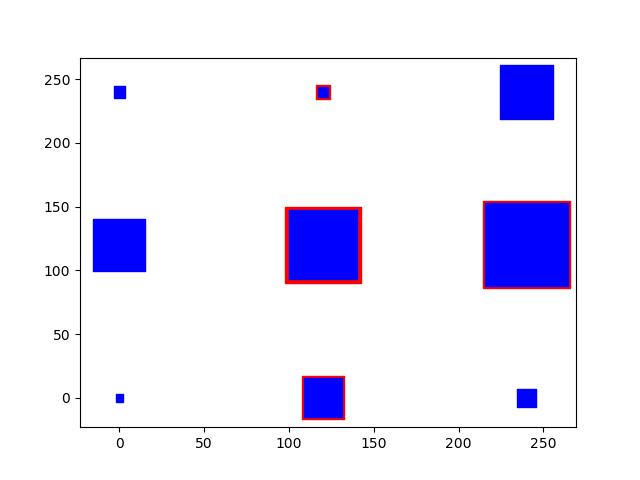

In [177]:
import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# Generating some random data.
# data = np.random.randint(0, 100, (1000,3))
x, y = chi1_16, chi2_16

# Generating raw view
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, marker='+', s=25, c='r')
# plt.show()

# Generating some grid with origin, cell size, and number of cells 10 10 10
numx, numy= 3, 3
origx, origy = 0, 0
sizex, sizey= 120, 120
grid = np.vstack(np.meshgrid(range(numx), range(numy))).reshape(2, -1).T
gy, gx = grid[:, 0]*sizex + origx, grid[:, 1]*sizey + origy

# Calculating the number of stars in each cell:
ix = ((x - origx)/sizex).astype(int)
iy = ((y - origy)/sizey).astype(int)
s16_2d = np.zeros((numx, numy))
c3_q16 = {}
for i in range(ix.shape[0]):
#     print s[ix[i], iy[i], iz[i]]
    s16_2d[ix[i], iy[i] ]= s16_2d[ix[i], iy[i]] + (1 *w_list[i]*10000)
    name = str(ix[i])+str(iy[i])
    set_key(c3_q16, name, i)
    
    
s16_2d = s16_2d.flatten()
mask = s16_2d > 0

# Plotting the result
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
plt.scatter(gx[mask], gy[mask], marker='s', s=s_2d[mask], c='r', edgecolor ="r")
plt.scatter(gx[mask], gy[mask], marker='s', s=s16_2d[mask], c='b', edgecolor ="b")

plt.show()

In [295]:
# w_list[(c3_q1[name])]
a_wlist=np.asanyarray(w_list)
print (a_wlist[(c3_q1['21'])]*10000).shape
s_2d

(3826,)


array([  12.0965  ,  735.642763,   13.448713,  932.443445, 3014.533094,
        101.819194,   77.809305, 3925.572847, 1186.633653])

<IPython.core.display.Javascript object>


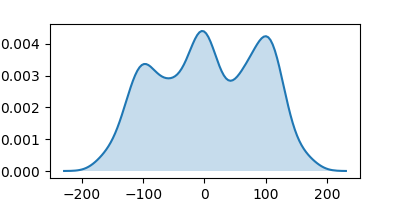

In [306]:
len(c3_q1['21'])
fig = plt.figure(figsize=(4,2)) 
sns.kdeplot(chi3_1[c3_q1['21']], shade=True) 

In [248]:
# len(c3_q1['10'])
dic_keys={'00':"pp", '01':'pt', '02':'pm', '10':'tp', '11':'tt', '12':'tm', '20':'mp',  '21':'mt', '22':'mm'} 
# dic_lims={'01':[-90,90], '02':[-60,60], '10':[-150,90], '11':[-90,90], '20':[-60,60],  '21':[-90,90], '22':[-95,150]} 
dic_lims={'01':[-90,90], '10':[-150,90], '11':[-90,90],  '21':[-90,90], '22':[-95,150]} 

<IPython.core.display.Javascript object>


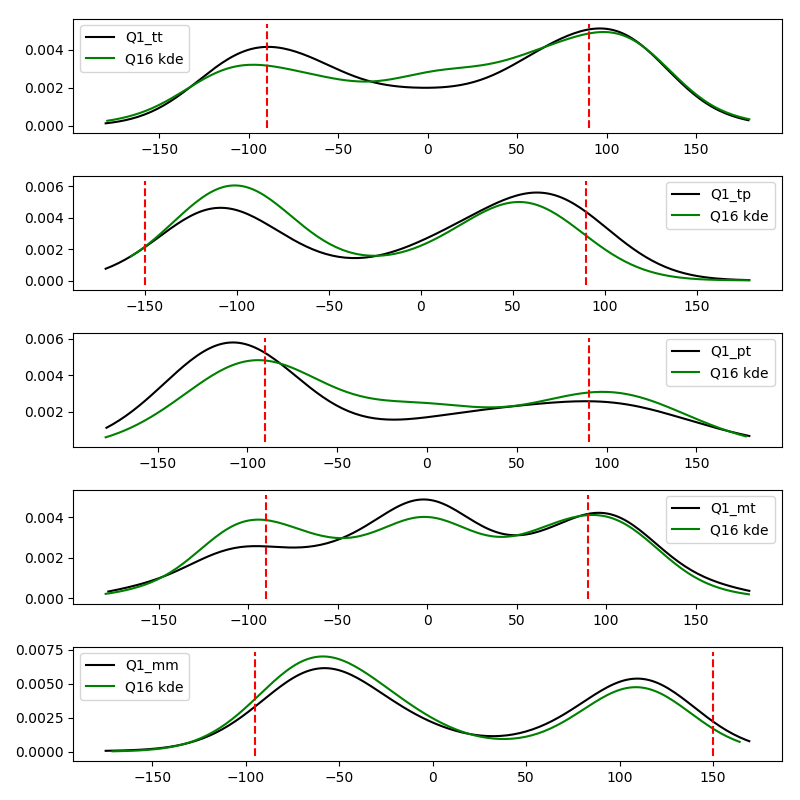

2648 11
832 10
976 01
3826 21
1392 22


In [302]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], linestyle='dashed', color='red')
    ax.add_line(l)
    return l



# for i in range(3):
#     for j in range(3):
#         name = str(i)+str(j)
#         name2 = str(j)+str(i)
#         fig = plt.figure()
#         pdf_d = gaussian_kde(np.array(chi3_1[np.asarray(c3_q1[name])]).astype(None), weights=a_wlist[(c3_q1[name])])
#         x = np.linspace(min(chi3_1[np.asarray(c3_q1[name])]), max(chi3_1[np.asarray(c3_q1[name])]), 200)
#         y = pdf_d(x)
# #         pdf_d16 = gaussian_kde(np.array(chi3_16[np.asarray(c3_q16[name])]).astype(None), weights=a_wlist[(c3_q16[name])])
# #         x16 = np.linspace(min(chi3_16[np.asarray(c3_q16[name])]), max(chi3_16[np.asarray(c3_q16[name])]), 200)
# #         y16 = pdf_d16(x16)
#         plt.plot(x, y, label="Q1 kde %s"%name2,color='green')  
# #         plt.plot(x16, y16, label='Q16 kde',color='black')  
# #         sns.kdeplot(, shade=True, label="Q1_%s"%name) 
# #         sns.kdeplot(chi3_16[np.asarray(c3_q16[name])], shade=True, label="Q16") 
#         plt.legend()
        
fig = plt.figure(figsize=(8,8))   
num = 511
for keys in dic_lims:
    name = keys #[1]+keys[0]
    a = [dic_lims[keys][0],0]
    b = [ dic_lims[keys][0], 0.006]
    a2 = [dic_lims[keys][1],0]
    b2 = [ dic_lims[keys][1], 0.006]
    
    plt.subplot(num)
    pdf_d = gaussian_kde(np.array(chi3_1[np.asarray(c3_q1[name])]).astype(None), weights=a_wlist[(c3_q1[name])])
    x = np.linspace(min(chi3_1[np.asarray(c3_q1[name])]), max(chi3_1[np.asarray(c3_q1[name])]), 200)
    y = pdf_d(x)
    plt.plot(x, y, label="Q1_%s"%dic_keys[keys],color='k')  
    pdf_d16 = gaussian_kde(np.array(chi3_16[np.asarray(c3_q16[name])]).astype(None), weights=a_wlist[(c3_q16[name])])
    x16 = np.linspace(min(chi3_16[np.asarray(c3_q16[name])]), max(chi3_16[np.asarray(c3_q16[name])]), 200)
    y16 = pdf_d16(x16)
    plt.plot(x16, y16, label='Q16 kde',color='green') 
    newline(a,b)
    newline(a2,b2)
    plt.plot()
    plt.legend()
    plt.tight_layout()
    num +=1
    print len(chi3_1[np.asarray(c3_q1[name])]), name

 


    

<IPython.core.display.Javascript object>


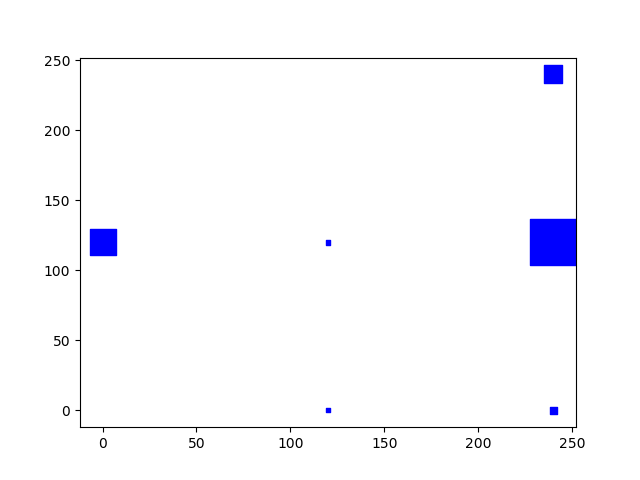

In [148]:
import numpy as np
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# Generating some random data.
# data = np.random.randint(0, 100, (1000,3))
x, y = chi1_1[hbonded_1], chi2_1[hbonded_1]

# Generating raw view
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, marker='+', s=25, c='r')
# plt.show()

# Generating some grid with origin, cell size, and number of cells 10 10 10
numx, numy= 3, 3
origx, origy = 0, 0
sizex, sizey= 120, 120
grid = np.vstack(np.meshgrid(range(numx), range(numy))).reshape(2, -1).T
gy, gx = grid[:, 0]*sizex + origx, grid[:, 1]*sizey + origy

# Calculating the number of stars in each cell:
ix = ((x - origx)/sizex).astype(int)
iy = ((y - origy)/sizey).astype(int)
s_2d_hb = np.zeros((numx, numy))
for i in range(ix.shape[0]):
#     print s[ix[i], iy[i], iz[i]]
    s_2d_hb[ix[i], iy[i] ]= s_2d_hb[ix[i], iy[i]] + (1 *w_list[i]*10000)
    
s_2d_hb = s_2d_hb.flatten()
mask = s_2d_hb > 0

# Plotting the result
fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
plt.scatter(gx[mask], gy[mask], marker='s', s=s_2d_hb[mask], c='b', edgecolor ="b")

plt.show()

<IPython.core.display.Javascript object>


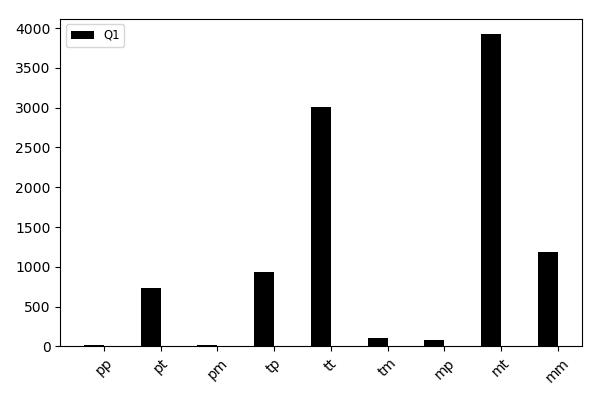

<IPython.core.display.Javascript object>


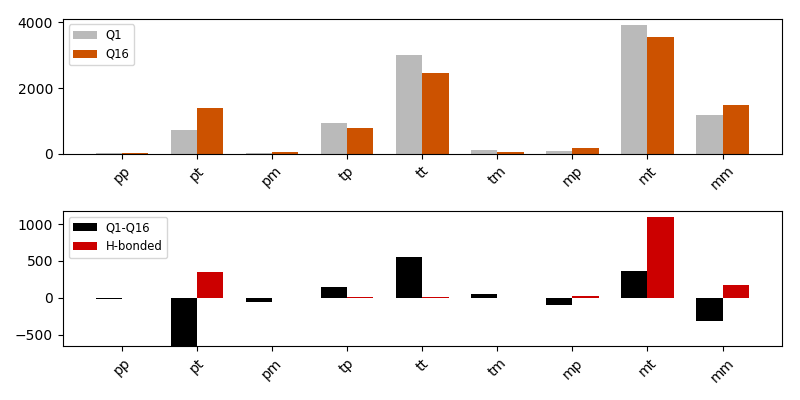

In [151]:
fig = plt.figure(figsize=(8,4))
ind = np.arange(9) 
width = 0.35     
categories = ['pp', 'pt', 'pm', 'tp', 'tt', 'tm', 'mp', 'mt', 'mm']
plt.subplot(211)
plt.bar(ind, s_2d, width, label='Q1', color='#bababa')
plt.bar(ind + width,s16_2d, width, label='Q16', color='#cc5200')
plt.xticks(ind + width / 2, categories,  rotation=45)
plt.legend(loc=2, fontsize='small')

plt.subplot(212)
plt.bar(ind, s_2d-s16_2d, width, label='Q1-Q16', color='k')
plt.bar(ind + width,s_2d_hb, width, label='H-bonded', color=[0.8,0,0])
plt.xticks(ind + width / 2, categories,  rotation=45)
plt.legend(loc=2, fontsize='small')

plt.tight_layout()
plt.savefig('hist.png', dpi=200)
plt.show()



In [149]:
gy_all = np.array([gx,gy]).T
for i in range(1,len(gy_all)+1):
    print 'g{}'.format(i), gy_all[i-1] , s_2d.flatten()[i-1]

g1 [0 0] 12.0965
g2 [  0 120] 735.6427630000003
g3 [  0 240] 13.448713
g4 [120   0] 932.4434449999997
g5 [120 120] 3014.5330940000017
g6 [120 240] 101.81919400000002
g7 [240   0] 77.80930499999995
g8 [240 120] 3925.572847000005
g9 [240 240] 1186.6336530000003


In [ ]:
iz[5:15]

In [ ]:
z[5:15]

In [135]:
# hbonded_16 = dists[:,4:5].min(1)<2.5
# np.where(hbonded_16)[0].shape
# helical = np.all(sslh[:,6:11]>0,1)
# helical
# hh = np.logical_and(helical, hbonded_1)
# hh.sum()

# X_true = np.array([np.logical_and(chi1_1>120, chi1_1<=240), np.logical_and(chi2_1>120, chi2_1<=240), np.logical_and(chi3_1>-60, chi3_1<=60)]).T
X_true = np.array([np.logical_and(chi1_1>120, chi1_1<=240), chi3_1<-60, np.logical_and(chi2_1>120, chi2_1<240)]).T

# X_true [1]
np.all(X_true>0,1).sum()


799

In [26]:
# 120<chi1_1<240
a = np.array([1,2,3,4,5,9])
np.logical_and(a>=6, a<=10)

array([False, False, False, False, False,  True])

In [ ]:
s[1,2,1]

In [ ]:
s#.flatten()

In [ ]:
# s16[mask]
(s-s16)/s

In [ ]:
gz[mask]

In [ ]:
gx[mask].reshape((9,3))

In [ ]:
# gy[mask]
grid

In [ ]:
gy_all = np.array([gx[mask],gy[mask], gz[mask]]).T


for i in range(1,28):
    print 'g{}'.format(i), gy_all[i-1] , s.flatten()[i-1], s16.flatten()[i-1]

<IPython.core.display.Javascript object>


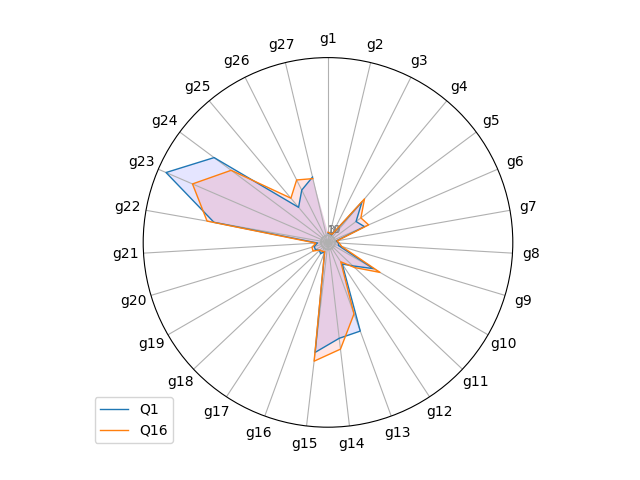

In [26]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data
# df = pd.DataFrame({
# 'group': ['Q1','Q16'],
# 'var1': [38, 1.5, 30, 4],
# 'var2': [29, 10, 9, 34],
# 'var3': [8, 39, 23, 24],
# 'var4': [7, 31, 33, 14],
# 'var5': [28, 15, 32, 14]
# })
 
 
 
# ------- PART 1: Create background
 
# number of variable
categories=['g{}'.format(i) for i in range(1,28)]
N = len(s[mask])
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
# angles += angles[:1]
 
# Initialise the spider plot
fig = plt.figure()
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles, categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1,10,30], ["1","10","30"], color="grey", size=7)
# plt.ylim(0,40)
 
 
## ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
norm = np.log(s[mask])
values= s[mask]
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Q1")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
# norm16 = np.log([float(i)/sum(s16[mask]) for i in s16[mask]])
values=(s16[mask])
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Q16")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))


In [ ]:
angles[:1]

<IPython.core.display.Javascript object>


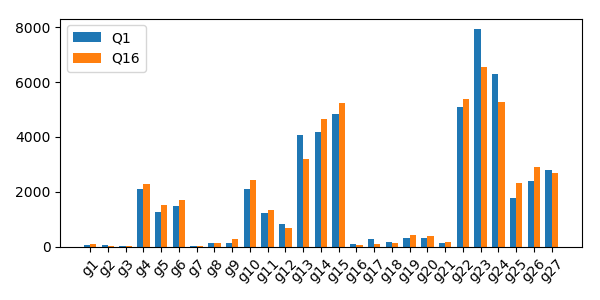

In [27]:
fig = plt.figure(figsize=(6,3))
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, s, width, label='Q1')
plt.bar(ind + width,s16, width, label='Q16')

# plt.ylabel('Scores')
# plt.title('Scores by group and gender')

plt.xticks(ind + width / 2, categories,  rotation=45)
plt.legend(loc=2)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


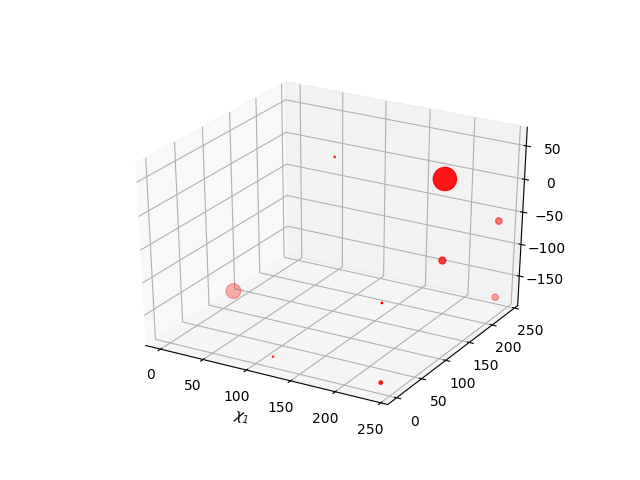

In [125]:
data = np.random.randint(0, 100, (1000,3))
x, y, z = chi1_1[hbonded_1], chi2_1[hbonded_1], chi3_1[hbonded_1]
# x, y, z = chi1_1[hbonded], chi2_1[hbonded], chi3_1[hh]

# Generating raw view
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, marker='+', s=25, c='r')
# plt.show()

# Generating some grid with origin, cell size, and number of cells 10 10 10
numx, numy, numz = 3, 3, 3
origx, origy, origz = 0, 0, -180
sizex, sizey, sizez = 120, 120, 120
grid = np.vstack(np.meshgrid(range(numx), range(numy), range(numz))).reshape(3, -1).T
gy, gx, gz = grid[:, 0]*sizex + origx, grid[:, 1]*sizey + origy, grid[:, 2]*sizez + origz

# Calculating the number of stars in each cell:
ix = ((x - origx)/sizex).astype(int)
iy = ((y - origy)/sizey).astype(int)
iz = ((z - origz)/sizez).astype(int)
s1_b = np.zeros((numx, numy, numz))
for i in range(ix.shape[0]):
#     print s[ix[i], iy[i], iz[i]]
    s1_b[ix[i], iy[i], iz[i]] = s1_b[ix[i], iy[i], iz[i]] + 1#(1*w_list[i]*10000)
    
s1_b = s1_b.flatten()
mask = s1_b > 0

# Plotting the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gx[mask], gy[mask], gz[mask], marker='o', s=s1_b[mask], c='r', edgecolor ="r")
# ax.scatter(gx[mask], gy[mask], gz[mask], marker='o', s=s16[mask], c='b', edgecolor ="r")
plt.xlabel(r'$\chi_1$');
plt.show()

In [138]:
gy_all = np.array([gx,gy, gz]).T
for i in range(1,len(gy_all)+1):
    print 'g{}'.format(i), gy_all[i-1] , s.flatten()[i-1]

 g1 [   0    0 -180] 11.0
g2 [  0   0 -60] 6.0
g3 [ 0  0 60] 4.0
g4 [   0  120 -180] 425.0
g5 [  0 120 -60] 249.0
g6 [  0 120  60] 302.0
g7 [   0  240 -180] 3.0
g8 [  0 240 -60] 23.0
g9 [  0 240  60] 29.0
g10 [ 120    0 -180] 412.0
g11 [120   0 -60] 257.0
g12 [120   0  60] 163.0
g13 [ 120  120 -180] 799.0
g14 [120 120 -60] 838.0
g15 [120 120  60] 1011.0
g16 [ 120  240 -180] 14.0
g17 [120 240 -60] 55.0
g18 [120 240  60] 32.0
g19 [ 240    0 -180] 56.0
g20 [240   0 -60] 58.0
g21 [240   0  60] 35.0
g22 [ 240  120 -180] 1000.0
g23 [240 120 -60] 1571.0
g24 [240 120  60] 1255.0
g25 [ 240  240 -180] 358.0
g26 [240 240 -60] 484.0
g27 [240 240  60] 550.0


<IPython.core.display.Javascript object>


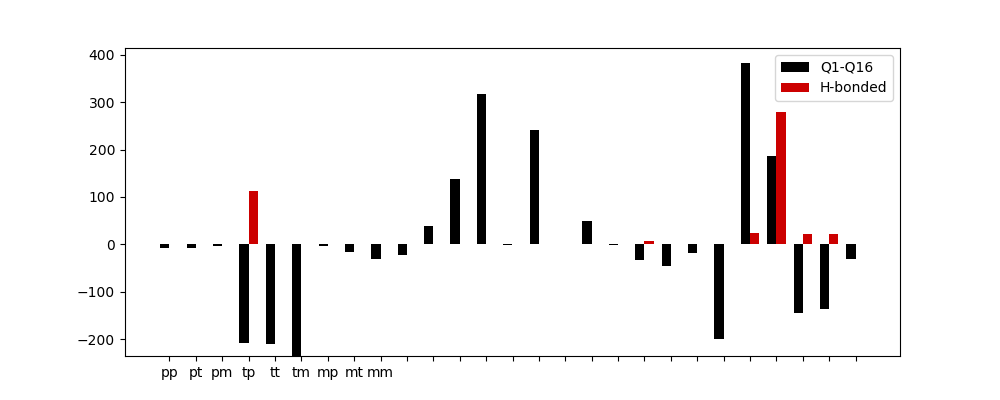

In [155]:
fig = plt.figure(figsize=(10,4))
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, s-s16, width, label='Q1-Q16', color='k')
plt.bar(ind + width,s1_b, width, label='H-bonded', color=[0.8,0,0])


# plt.ylabel('Scores')
# plt.title('Scores by group and gender')

plt.xticks(ind + width / 2, categories)
plt.legend(loc='best')
plt.savefig('hist_diff.png', dpi=200)
plt.show()

<IPython.core.display.Javascript object>


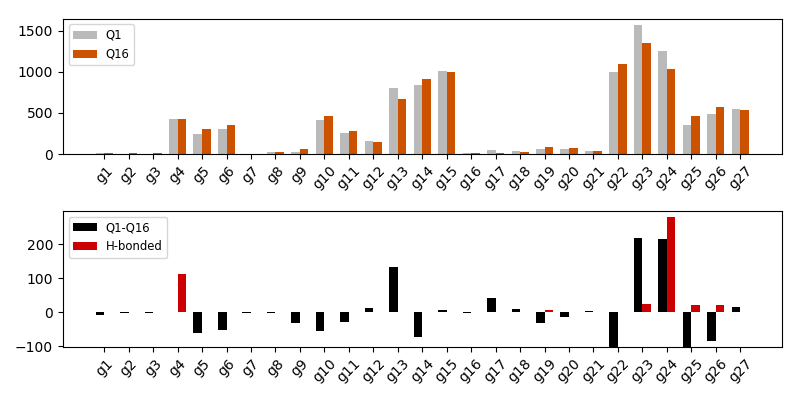

In [126]:
fig = plt.figure(figsize=(8,4))
ind = np.arange(N) 
width = 0.35       
plt.subplot(211)
plt.bar(ind, s, width, label='Q1', color='#bababa')
plt.bar(ind + width,s16, width, label='Q16', color='#cc5200')
plt.xticks(ind + width / 2, categories,  rotation=45)
plt.legend(loc=2, fontsize='small')

plt.subplot(212)
plt.bar(ind, s-s16, width, label='Q1-Q16', color='k')
plt.bar(ind + width,s1_b, width, label='H-bonded', color=[0.8,0,0])
plt.xticks(ind + width / 2, categories,  rotation=45)
plt.legend(loc=2, fontsize='small')

plt.tight_layout()
plt.savefig('hist.png', dpi=200)
plt.show()

In [ ]:
df.iloc[:,2:4]

In [ ]:
c_x1 = [0, 120, 240, 360]
c_x2 = [0, 120, 240, 360]
c_x3 = [-180, -40, 40, 180]
for i in range():
    for j in range():
        for k in range():

In [ ]:
s16[mask]

## DBSCAN

In [77]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import mixture
from sklearn.preprocessing import StandardScaler

In [ ]:
X = np.array([chi1_1, chi2_1, chi3_1]).T
X = StandardScaler().fit_transform(X)
weights = np.array(w_list, np.float)
n_weights = weights*10000
# mean_w = np.mean(weights)
# n_weights = (weights-min(weights))/(max(weights)-min(weights))

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X, sample_weight=n_weights)
colors = sns.color_palette("hls", db.labels_.max()+1)
# for i in np.arange(-1, db.labels_.max()):
#     plt.plot(chi1_1[db.labels_==i], chi2_1[db.labels_==i], '.', color=colors[i+1])
print("Number of clusters:",db.labels_.max())

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(14,14))
ax = plt.axes(projection='3d')
for i in np.arange(-1, db.labels_.max()):
    ax.plot(chi1_1[db.labels_==i], chi2_1[db.labels_==i], chi3_1[db.labels_==i], '.', color=colors[i+1])
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
# plt.zlabel(r'$\chi_3$');
# i=-1
# ax.plot(chi1_1[db.labels_==i], chi2_1[db.labels_==i], chi3_1[db.labels_==i], '.', color=colors[i+1])

In [ ]:
db.labels_.max()

In [ ]:
X16 = np.array([chi1_16, chi2_16, chi3_16]).T
X16 = StandardScaler().fit_transform(X16)

In [ ]:
db_16 = DBSCAN(eps=0.3, min_samples=10).fit(X16, sample_weight=n_weights)
colors = sns.color_palette("hls", db_16.labels_.max()+5)
# for i in np.arange(-1, db.labels_.max()):
#     plt.plot(chi1_1[db.labels_==i], chi2_1[db.labels_==i], '.', color=colors[i+1])
print("Number of clusters:",db_16.labels_.max())

In [ ]:
fig = plt.figure(figsize=(14,14))
ax = plt.axes(projection='3d')
for i in np.arange(-1, db_16.labels_.max()):
    ax.plot(chi1_16[db_16.labels_==i], chi2_16[db_16.labels_==i], chi3_16[db_16.labels_==i], '.', color=colors[i+1])
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
# i=0
# # # j=
# ax.plot(chi1_16[db_16.labels_==i], chi2_16[db_16.labels_==i], chi3_16[db_16.labels_==i], '.', color=colors[i+1])
# ax.plot(chi1_1[db.labels_==j], chi2_1[db.labels_==j], chi3_1[db.labels_==j], '.', color=colors[j+1])

In [ ]:
f, ax= plt.subplots(2, 3)


for i in np.arange(-1, db.labels_.max()):
    ax[0, 0].plot(chi1_1[db.labels_==i], chi2_1[db.labels_==i], '.', color=colors[i+1])

for i in np.arange(-1, db_16.labels_.max()):
    ax[1, 0].plot(chi1_16[db_16.labels_==i], chi2_16[db_16.labels_==i], '.', color=colors[i+1])


for i in np.arange(-1, db.labels_.max()):
    ax[0, 1].plot(chi1_1[db.labels_==i], chi3_1[db.labels_==i], '.', color=colors[i+1]) 

for i in np.arange(-1, db_16.labels_.max()):
    ax[1, 1].plot(chi1_16[db_16.labels_==i], chi3_16[db_16.labels_==i], '.', color=colors[i+1])    


for i in np.arange(-1, db.labels_.max()):
    ax[0, 2].plot(chi2_1[db.labels_==i], chi3_1[db.labels_==i], '.', color=colors[i+1]) 

for i in np.arange(-1, db_16.labels_.max()):
    ax[1, 2].plot(chi2_16[db_16.labels_==i], chi3_16[db_16.labels_==i], '.', color=colors[i+1])    

# plt.xlabel(r'$\chi_1$');
# plt.ylabel(r'$\chi_2$');

In [ ]:
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'red', 'green', 'black', 'brown'])
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
# fig = plt.figure(figsize=(14,14))

gmm = mixture.GaussianMixture(n_components=7, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

dpgmm = mixture.BayesianGaussianMixture(n_components=7,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

# Cluster of the helices

In [75]:
mm = md.load('/home/btopal/pQ_sims/KKPGASL4Q16KK/charmm/200ns/3/5ms_nowater_16q.xtc', 
             top='/home/btopal/pQ_sims/KKPGASL4Q16KK/charmm/200ns/3/2ms_nowater_16q.pdb')
# mm = md.load('/home/btopal/cs_analysis/charmm/16q/combined.xtc', 
#              top='/home/btopal/cs_analysis/charmm/16q/cs_pro_0.pdb')
# mm.time = np.linspace(0,5000,mm.n_frames)
mm = mm[::5]
topmm = mm.top
ssl = md.compute_dssp(mm,simplified=True)
sslh = (ssl=='H').astype(np.float)
sslh

array([[0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [78]:
X_h = np.array(sslh)
X_h = StandardScaler().fit_transform(X_h)
weights = np.array(w_list, np.float)
# mean_w = np.mean(weights)
# n_weights = (weights-min(weights))/(max(weights)-min(weights))
n_weights = 10000*weights

In [79]:
db_h = DBSCAN(eps=3, min_samples=5, algorithm= 'kd_tree', leaf_size =40).fit(X_h)#, sample_weight=n_weights)
colors = sns.color_palette("hls", db_h.labels_.max()+5)
# for i in np.arange(-1, db.labels_.max()):
#     plt.plot(chi1_1[db.labels_==i], chi2_1[db.labels_==i], '.', color=colors[i+1])
print("Number of clusters:",db_h.labels_.max())

('Number of clusters:', 28)


In [80]:
# fig = plt.figure(figsize=(15,10))
for i in np.arange(-1, db_h.labels_.max()+1):
    print i, sslh[db_h.labels_==i].shape 
#     plt.plot(sslh[db_h.labels_==i].mean(0), label='H',  color=colors[i+1])
# plt.xticks(np.arange(28),'KKPGAS'+'L'*4+'Q'*16+'KK');

-1 (261, 28)
0 (37, 28)
1 (30, 28)
2 (51, 28)
3 (412, 28)
4 (6042, 28)
5 (226, 28)
6 (19, 28)
7 (5, 28)
8 (67, 28)
9 (5, 28)
10 (6, 28)
11 (2085, 28)
12 (36, 28)
13 (8, 28)
14 (39, 28)
15 (189, 28)
16 (15, 28)
17 (73, 28)
18 (163, 28)
19 (133, 28)
20 (11, 28)
21 (9, 28)
22 (13, 28)
23 (11, 28)
24 (16, 28)
25 (5, 28)
26 (4, 28)
27 (5, 28)
28 (24, 28)


In [ ]:
np.arange(0)


In [ ]:
sslh[db_h.labels_==-1].shape

<IPython.core.display.Javascript object>


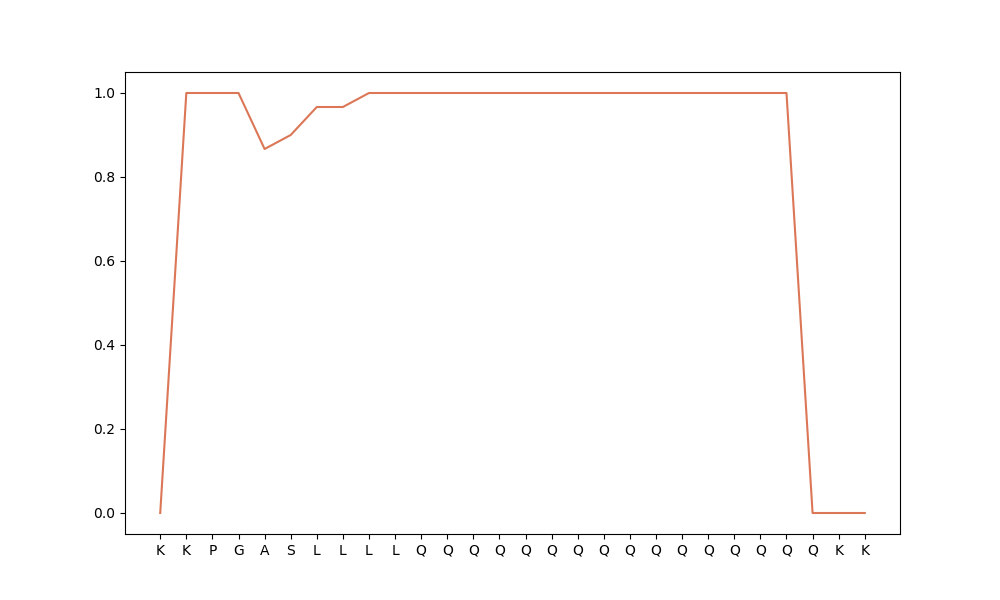

In [82]:
plt.figure(figsize=(10,6))
plt.plot(sslh[db_h.labels_==1].mean(0), label='H',  color=colors[1])
plt.xticks(np.arange(28),'KKPGAS'+'L'*4+'Q'*16+'KK');

In [81]:
for i in np.arange(-1, db_h.labels_.max()+1):
    print i, sslh[db_h.labels_==i].shape ,weights[db_h.labels_==i].mean(), n_weights[db_h.labels_==i].mean()

-1 (261, 28) 0.0001656295643678161 1.656295643678161
0 (37, 28) 0.0008075175675675676 8.075175675675677
1 (30, 28) 0.0008689346666666667 8.689346666666667
2 (51, 28) 0.0007618733333333333 7.618733333333332
3 (412, 28) 0.0001604218390776699 1.6042183907766991
4 (6042, 28) 0.00010871603968884475 1.0871603968884473
5 (226, 28) 0.00014512487610619467 1.451248761061947
6 (19, 28) 0.0004095842105263158 4.0958421052631575
7 (5, 28) 0.000312268 3.12268
8 (67, 28) 6.326192537313432e-05 0.6326192537313432
9 (5, 28) 0.00011817560000000001 1.181756
10 (6, 28) 5.430766666666667e-05 0.5430766666666667
11 (2085, 28) 1.8138367242206238e-05 0.18138367242206235
12 (36, 28) 0.00014690680555555556 1.4690680555555558
13 (8, 28) 0.000100134625 1.00134625
14 (39, 28) 0.00014902428205128206 1.4902428205128206
15 (189, 28) 5.698380529100529e-05 0.569838052910053
16 (15, 28) 6.172533333333334e-05 0.6172533333333333
17 (73, 28) 0.000149581602739726 1.4958160273972603
18 (163, 28) 6.084887975460123e-05 0.60848879

In [ ]:
ll=[]
plt.figure(figsize=(10,6))
for i in np.arange(-1, db_h.labels_.max()+1):
    ll.append(n_weights[db_h.labels_==i].mean())
order =np.argsort(ll)
mycolors = sns.color_palette('BuPu',n_colors=len(ll))

for i,c in zip(order, mycolors):
    plt.plot(sslh[db_h.labels_==i].mean(0), 'o',label='H',alpha=.7,color=c)
plt.xticks(np.arange(28),'KKPGAS'+'L'*4+'Q'*16+'KK');

In [ ]:
sns.color_palette('BuPu', n_colors=)

In [307]:
view = nv.show_mdtraj(mm[245])
view

# view.add_component('/home/btopal/fishing/16q/data/out_245.pdb')
view.clear_representations()
view.render_image()
view._display_image()

A Jupyter Widget

In [ ]:
new_sslh = sslh[db_h.labels_==-1]
# new_sslh
X_h = np.array(new_sslh)
X_h = StandardScaler().fit_transform(X_h)

db_h = DBSCAN(eps=0.3, min_samples=5).fit(X_h)
colors = sns.color_palette("hls", db_h.labels_.max()+5)
# for i in np.arange(-1, db.labels_.max()):
#     plt.plot(chi1_1[db.labels_==i], chi2_1[db.labels_==i], '.', color=colors[i+1])
print("Number of clusters:",db_h.labels_.max())

In [ ]:
fig = plt.figure(figsize=(15,10))
for i in np.arange(-1, db_h.labels_.max()+1):
    print i, new_sslh[db_h.labels_==i].shape 
    plt.plot(new_sslh[db_h.labels_==i].mean(0), label='H',  color=colors[i+1])
plt.xticks(np.arange(28),'KKPGAS'+'L'*4+'Q'*16+'KK');

In [ ]:
sslh[db_h.labels_==-1]

In [ ]:
matplotlib.__version__

In [ ]:
import matplotlib

In [317]:
np.where(db_h.labels_==6)


(array([ 154,  161, 1214, 1216, 1217, 1218, 1219, 1220, 1222, 1223, 1224,
        1225, 1226, 1229, 1230, 1231, 1232, 1233, 1234]),)

In [ ]:
plt.show()

In [327]:
pwd

u'/g/lmb/home/btopal/jup'

In [331]:
cp /g/lmb/home/btopal/fishing/16q/data/out_1000.pdb .

In [340]:
md.formats.PDBTrajectoryFile.write('out_1000.pdb', mode='w', force_overwrite=True)

TypeError: unbound method write() must be called with PDBTrajectoryFile instance as first argument (got str instance instead)

In [341]:
aa.write('out.pdb')

TypeError: write() takes at least 3 arguments (2 given)